In [1]:
import json, csv
import pandas as pd
import numpy as np
import parse_xml
import requests 
import subprocess
import os 
import urllib.parse
import urllib.request
import biomedkg_utils
import biomed_apis
import requests
from bs4 import BeautifulSoup
import html
from biomed_apis import *
from biomedkg_utils import *
from parse_xml import *
from lxml import etree
import xml.etree.ElementTree as ET
from multiprocessing import Pool, cpu_count
from multiprocessing import Process

In [3]:
# You need an authorized DrugBank account for this
# ! curl -Lfv -o input/drugbank_all_full_database.xml.zip -u USERNAME:PASSWORD https://go.drugbank.com/releases/5-1-9/downloads/all-full-database
#! unzip input/drugbank_all_full_database.xml.zip
#! mv 'full database.xml' input/full_drugbank.xml

## DrugBank - Protein
- Drugs-[targets, carried_by, transported_by, or uses_enzyme]->Protein

In [2]:
tree = ET.parse('input/full_drugbank.xml')
root = tree.getroot()

##### Makes dataframe of selected info about all drugs

In [3]:
compoundprotein_df = pd.DataFrame(columns=['ID','Name','Synonyms','ATC','Pathways','Indications','Drug-->Protein'])
for i, ele in enumerate(root):
    print(i, end = '\r')
    
    name = ParseXML.getName(ele)                               # Drug name
    syn = [drug.lower() for drug in ParseXML.getSynonyms(ele)] # Drug synonyms
    ID = ParseXML.getID(ele)    # DrugBank ID
    indications = ParseXML.getIndication(ele)                  # Description of indications
    pathways = ParseXML.getPathways(ele)                       # SMPDB Pathway information (drug targets pathways)
    atc = ParseXML.getATCCode(ele)                             # ATC, drug classification code
    
    # Drug-[relationship]->Protein dictionary
    d2p = []
    for relation in ['carriers', 'targets', 'transporters' , 'enzymes']:
        d2p.append({relation:ParseXML.getEntities(ele, relation)})

    compoundprotein_df.loc[len(compoundprotein_df.index)] = [ID, name, syn, atc, pathways, indications,d2p]
compoundprotein_df.head(2)

,ID,Name,Synonyms,ATC,Pathways,Indications,Drug-->Protein
0,DB00001,Lepirudin,"[hirudin variant-1, lepirudin, lepirudin recom...",[B01AE02],"[{'name': 'Lepirudin Action Pathway', 'smpdb_i...",For the treatment of heparin-induced thrombocy...,"[{'carriers': []}, {'targets': [{'name': 'Prot..."
1,DB00002,Cetuximab,"[cetuximab, cétuximab, cetuximabum]",[L01XC06],"[{'name': 'Cetuximab Action Pathway', 'smpdb_i...",Cetuximab indicated for the treatment of local...,"[{'carriers': []}, {'targets': [{'name': 'Epid..."


## Drug->Protein dictionary
Relationships: Targets, Carries, Transports, Enyzmes

In [74]:
# Option 2: Use Dictionaries for each relationship: {Drug: [upids], ...}
count = 0
drug_targets_prot, drug_carry_prot, drug_transport_prot, drug_enzyme_prot = dict(), dict(), dict(), dict()
drugTargetsProtrelationships = 0
with open('output/compound2protein/edges_compoundprotein_drugbank.csv', 'w') as fout,\
    open('output/compound2protein/edges_compoundprotein_mesh.csv','w') as fout1:
    writer = csv.writer(fout)
    writer.writerow(['Compound (DrugBank)', 'Protein (UniProt)','Relationship'])
    
    writer2 = csv.writer(fout1)
    writer2.writerow(['Compound (MeSH)', 'Protein (UniProt)', 'Relationship'])
    
    for count, ele in enumerate(root):
        ID = ParseXML.getID(ele)
        for relation in ['carriers', 'targets', 'transporters' , 'enzymes']:
            prots = ParseXML.getEntities(ele, relation)
            
            for prot in prots:
                upid = prot['uniprot_id']
                if(upid != 'Null'):
                    
                    if(relation == 'carriers'):
                        drug_carry_prot.setdefault(ID,[]).append(upid)

                    elif(relation == 'targets'):
                        drug_targets_prot.setdefault(ID,[]).append(upid)
                        drugTargetsProtrelationships += 1

                    elif(relation == 'transporters'):
                        drug_transport_prot.setdefault(ID,[]).append(upid)

                    elif(relation == 'enzymes'):
                        drug_enzyme_prot.setdefault(ID,[]).append(upid)

            for prot in prots:
                upid = prot['uniprot_id']
                if(upid != 'Null'):
                    if relation == 'targets':
                        writer.writerow(['DrugBank_Compound:'+ID, 'UniProt:'+upid, '-drug_%s_protein->'%relation])
                        try:
                            mesh_compounds = db2mesh[ID]
                            for mesh in mesh_compounds:
                                writer2.writerow(['MeSH_Compound:'+mesh, 'UniProt:'+upid, '-drug_%s_protein->'%relation])
                        except:
                            continue

                    else:
                        writer.writerow(['DrugBank_Compound:'+ID, 'UniProt:'+upid, '-drug_uses_protein_as_%s-'%relation])
                        try:
                            mesh_compounds = db2mesh[ID]
                            for mesh in mesh_compounds:
                                writer2.writerow(['MeSH_Compound:'+mesh, 'UniProt:'+upid, '-drug_uses_protein_as_%s-'%relation])
                        except:
                            continue
print('drugTargetsProtrelationships', drugTargetsProtrelationships)
                        

drugwithtarget = 0
num_actions, num_prots, num_drugs = 0, 0, 0 
uniq_acts, uniq_prot, unique_drug = dict(), set(), set()
with open('output/compound2protein/edges_compoundsometargetsdetailed_drugbank.csv', 'w') as fout,\
    open('output/compound2protein/edges_compoundsometargetsdetailed_mesh.csv', 'w') as fout1:

    writer = csv.writer(fout)
    writer.writerow(['Compound (DrugBank)','Protein (UniProt)', 'Relationship'])
    
    writer2 = csv.writer(fout1)
    writer2.writerow(['Compound (MeSH)', 'Protein (UniProt)', 'Relationship'])
    
    for ele in root:
        ID = ParseXML.getID(ele)
        prots = ParseXML.getEntities(ele, 'targets')
        
        if len(prots) > 0:
            drugwithtarget += 1
            has_action = False
            for prot in prots:
                upid = prot['uniprot_id']
                actions = prot['actions']
                uniq_prot.add(upid)
                num_prots += 1
                
                if(upid != 'Null'):
                    if len(actions) > 0:
                        has_action = True
                        for action in actions:
                            
                            # DrugBank Compound
                            writer.writerow(['DrugBank_Compound:'+ID, 'UniProt:'+upid, '-%s->'%action.replace(' ','_')])
                            uniq_acts.setdefault(action,0)
                            num_actions += 1
                            uniq_acts[action] += 1
                            
                            # MeSH Compound
                            try:
                                mesh_compounds = db2mesh[ID]
                                for mesh in mesh_compounds:
                                    writer2.writerow(['MeSH_Compound:'+mesh, 'UniProt:'+upid, '-%s->'%action.replace(' ','_')])
                            except:
                                continue
                    else:
                        # DrugBank Compound
                        writer.writerow(['DrugBank_Compound:'+ID, 'UniProt:'+upid, '-drug_targets_protein->'])
                        
                        # MeSH Compound
                        try:
                            mesh_compounds = db2mesh[ID]
                            for mesh in mesh_compounds:
                                writer2.writerow(['MeSH_Compound:'+mesh, 'UniProt:'+upid, '-drug_targets_protein->'])
                        except:
                            continue


            if has_action == True:
                num_drugs += 1
                unique_drug.add(ID)

! cp 'output/compound2protein/edges_compoundsometargetsdetailed_drugbank.csv' 'output/edges/edges_compoundsometargetsdetailed_drugbank.csv'
! cp 'output/compound2protein/edges_compoundsometargetsdetailed_mesh.csv' 'output/edges/edges_compoundsometargetsdetailed_mesh.csv'
! cp 'output/compound2protein/edges_compoundprotein_drugbank.csv' 'output/edges/edges_compoundprotein_drugbank.csv'
! cp 'output/compound2protein/edges_compoundprotein_mesh.csv' 'output/edges/edges_compoundprotein_mesh.csv'
                
print('Drug with Target:', drugwithtarget)
print('Total Drug-action-Target Relationships:',num_actions, num_prots, num_drugs)
print('Unique Actions:',len(uniq_acts), 'Unique Proteins:',len(uniq_prot), 'Unique Drugs:',len(unique_drug))
print('Actions:')
uniq_acts

drugTargetsProtrelationships 14421
Drug with Target: 5927
Total Drug-action-Target Relationships: 7498 14654 2261
Unique Actions: 47 Unique Proteins: 2802 Unique Drugs: 2261
Actions:


{'inhibitor': 2422,
 'binder': 377,
 'agonist': 1240,
 'antibody': 82,
 'ligand': 335,
 'activator': 176,
 'inducer': 118,
 'modulator': 74,
 'substrate': 84,
 'cofactor': 193,
 'antagonist': 1693,
 'chaperone': 17,
 'product of': 41,
 'downregulator': 16,
 'other/unknown': 63,
 'stimulator': 21,
 'negative modulator': 33,
 'positive allosteric modulator': 69,
 'inverse agonist': 27,
 'other': 31,
 'partial agonist': 94,
 'potentiator': 146,
 'unknown': 18,
 'blocker': 35,
 'inhibitory allosteric modulator': 2,
 'allosteric modulator': 11,
 'multitarget': 7,
 'stabilization': 9,
 'partial antagonist': 1,
 'suppressor': 3,
 'binding': 9,
 'degradation': 1,
 'incorporation into and destabilization': 1,
 'weak inhibitor': 1,
 'neutralizer': 3,
 'cleavage': 5,
 'oxidizer': 3,
 'inactivator': 6,
 'nucleotide exchange blocker': 1,
 'regulator': 14,
 'inhibition of synthesis': 1,
 'antisense oligonucleotide': 4,
 'translocation inhibitor': 1,
 'gene replacement': 1,
 'inhibits downstream infl

#### Get Proteins in Drug-Protein Relationships

In [1]:
d = {'inhibitor': 2422,
 'binder': 377,
 'agonist': 1240,
 'antibody': 82,
 'ligand': 335,
 'activator': 176,
 'inducer': 118,
 'modulator': 74,
 'substrate': 84,
 'cofactor': 193,
 'antagonist': 1693,
 'chaperone': 17,
 'product of': 41,
 'downregulator': 16,
 'other/unknown': 63,
 'stimulator': 21,
 'negative modulator': 33,
 'positive allosteric modulator': 69,
 'inverse agonist': 27,
 'other': 31,
 'partial agonist': 94,
 'potentiator': 146,
 'unknown': 18,
 'blocker': 35,
 'inhibitory allosteric modulator': 2,
 'allosteric modulator': 11,
 'multitarget': 7,
 'stabilization': 9,
 'partial antagonist': 1,
 'suppressor': 3,
 'binding': 9,
 'degradation': 1,
 'incorporation into and destabilization': 1,
 'weak inhibitor': 1,
 'neutralizer': 3,
 'cleavage': 5,
 'oxidizer': 3,
 'inactivator': 6,
 'nucleotide exchange blocker': 1,
 'regulator': 14,
 'inhibition of synthesis': 1,
 'antisense oligonucleotide': 4,
 'translocation inhibitor': 1,
 'gene replacement': 1,
 'inhibits downstream inflammation cascades': 1,
 'chelator': 4,
 'component of': 4}

(array([42.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([1.0000e+00, 2.4310e+02, 4.8520e+02, 7.2730e+02, 9.6940e+02,
        1.2115e+03, 1.4536e+03, 1.6957e+03, 1.9378e+03, 2.1799e+03,
        2.4220e+03]),
 <BarContainer object of 10 artists>)

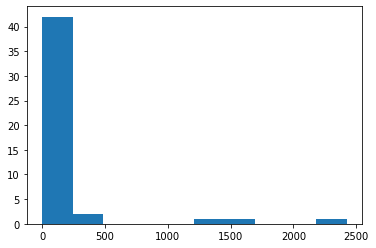

In [5]:
import matplotlib.pyplot as plt
plt.hist([i[1] for i in sorted(d.items(), key = lambda x:x[1], reverse=True)])

In [3]:
sorted(d.items(), key = lambda x:x[1], reverse=True)

[('inhibitor', 2422),
 ('antagonist', 1693),
 ('agonist', 1240),
 ('binder', 377),
 ('ligand', 335),
 ('cofactor', 193),
 ('activator', 176),
 ('potentiator', 146),
 ('inducer', 118),
 ('partial agonist', 94),
 ('substrate', 84),
 ('antibody', 82),
 ('modulator', 74),
 ('positive allosteric modulator', 69),
 ('other/unknown', 63),
 ('product of', 41),
 ('blocker', 35),
 ('negative modulator', 33),
 ('other', 31),
 ('inverse agonist', 27),
 ('stimulator', 21),
 ('unknown', 18),
 ('chaperone', 17),
 ('downregulator', 16),
 ('regulator', 14),
 ('allosteric modulator', 11),
 ('stabilization', 9),
 ('binding', 9),
 ('multitarget', 7),
 ('inactivator', 6),
 ('cleavage', 5),
 ('antisense oligonucleotide', 4),
 ('chelator', 4),
 ('component of', 4),
 ('suppressor', 3),
 ('neutralizer', 3),
 ('oxidizer', 3),
 ('inhibitory allosteric modulator', 2),
 ('partial antagonist', 1),
 ('degradation', 1),
 ('incorporation into and destabilization', 1),
 ('weak inhibitor', 1),
 ('nucleotide exchange bloc

In [44]:
d_proteins = set()

for count, ele in enumerate(root):
    for relation in ['carriers', 'targets', 'transporters' , 'enzymes']:
        
        prots = ParseXML.getEntities(ele, relation)
        for prot in prots:
            upid = prot['uniprot_id']
            if(upid != 'Null'):
                d_proteins.add(upid)

### Export Drugs, Drug-Protein

In [ ]:
drugbankIDs = list(compoundprotein_df['ID'])
compoundprotein_df['ID'].to_csv('output/compound2compound/drugbankIDs')

# Export Drug-Protein
json.dump(drug_targets_prot, open("output/compound2protein/compound_targets_prot.json","w"))
json.dump(drug_carry_prot, open("output/compound2protein/compound_carry_prot.json","w"))
json.dump(drug_transport_prot,open("output/compound2protein/compound_transport_prot.json","w"))
json.dump(drug_enzyme_prot,open("output/compound2protein/compound_enzyme_prot.json","w"))
json.dump(list(d_proteins),open("output/compound2protein/drugs_proteins.json","w"))


## Resume Drug-Target

## TTD: Drug-Target
Therapeutic Targets Database

In [3]:
# TTD Drug -is- DrugBank Drug
ttd2db = json.load(open('output/compound2compound/ttd2db.json'))

### TTD Drug -targets-> UniProt Protein

#### TTD Drug-[targets]-> TTD Protein 


In [4]:
! wget -N -P input/ http://db.idrblab.net/ttd/sites/default/files/ttd_database/P1-07-Drug-TargetMapping.xlsx
target2compound_df = pd.read_excel('input/P1-07-Drug-TargetMapping.xlsx')
target2compound_df['Highest_status'].value_counts()

--2023-06-06 21:09:59--  http://db.idrblab.net/ttd/sites/default/files/ttd_database/P1-07-Drug-TargetMapping.xlsx
Resolving db.idrblab.net (db.idrblab.net)... 47.88.56.212
Connecting to db.idrblab.net (db.idrblab.net)|47.88.56.212|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://db.idrblab.net/ttd/sites/default/files/ttd_database/P1-07-Drug-TargetMapping.xlsx [following]
--2023-06-06 21:10:00--  https://db.idrblab.net/ttd/sites/default/files/ttd_database/P1-07-Drug-TargetMapping.xlsx
Connecting to db.idrblab.net (db.idrblab.net)|47.88.56.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1171234 (1.1M)
Saving to: ‘input/P1-07-Drug-TargetMapping.xlsx’

P1-07-Drug-TargetMa 100%[===================>]   1.12M  5.84MB/s    in 0.2s    

2023-06-06 21:10:00 (5.84 MB/s) - ‘input/P1-07-Drug-TargetMapping.xlsx’ saved [1171234/1171234]



Investigative                      24859
Patented                            6017
Phase 2                             2624
Approved                            2617
Phase 1                             2497
Terminated                          1449
Phase 3                             1088
Discontinued in Phase 2              922
Phase 1/2                            734
Discontinued in Phase 1              576
Preclinical                          520
Discontinued in Phase 3              218
Phase 2/3                            128
Clinical trial                        70
Withdrawn from market                 56
Phase 4                               54
Phase 3 Trial                         48
Discontinued in Phase 1/2             33
Phase 2 Trial                         27
Discontinued in Preregistration       26
Preregistration                       12
Phase 2/3 Trial                       12
Phase 2a                              11
Phase 1 Trial                          9
Registered      

In [6]:
target2compound_df

,TargetID,DrugID,Highest_status,MOA
0,T71390,D07OAC,Investigative,Inhibitor
1,T70309,D07OAC,Investigative,Inhibitor
2,T97071,D0Y6UB,Investigative,Inhibitor
3,T86679,D0J2UW,Investigative,Agonist
4,T19229,D0UZ9U,Investigative,Modulator
...,...,...,...,...
44658,T31543,D0U4EO,Patented,Inhibitor
44659,T12797,D03TTE,Patented,Inhibitor
44660,T12797,D0B1UL,Patented,Inhibitor
44661,T21357,D0X5XB,Patented,Inhibitor


In [7]:
''' TTD Drug-targets-> TTD Protein '''
ttd2ttdtarget, ttd2ttdtarget_allstatuses = dict(), dict()
all_ttdtargets = set()
for i in range(0,len(target2compound_df)):
    
    # TTD Drug
    drug = target2compound_df['DrugID'][i]
    if drug in ttd2db:
        
        # Protein target
        ttd_target = target2compound_df['TargetID'][i]
        
        # Approval status (e.g., Approved, Patented)
        status = target2compound_df['Highest_status'][i]
        
        # Save drug->target mapping
        ttd2ttdtarget_allstatuses.setdefault(drug,[]).append(ttd_target)
        all_ttdtargets.add(ttd_target)
        if status == 'Patented' or status == 'Approved' or status == 'Phase 3':
            ttd2ttdtarget.setdefault(drug,[]).append(ttd_target)
        
len(all_ttdtargets)

451

### TTD Target ID -[is]->  UniProt ID

#### TTD Target ID-[is]-UniProt Name

In [24]:
! wget -N -P input/ http://db.idrblab.net/ttd/sites/default/files/ttd_database/P1-01-TTD_target_download.txt

''' Align UniProt name to TTD Target ID '''
info = []
up_name2ttdtarg, ttdtarg2up_name = dict(), dict()
with open('input/P1-01-TTD_target_download.txt','r') as fin:
    for i, line in enumerate(fin):
        # Start when table starts
        if i < 41:
            continue
            
        ### TTD ID -is- UniProt Name
        if ((line == '\n' or line.startswith('\t') or line == '') and info != []):
            ttdid, uniprot = getTTD_to_UniProtname(info)
            uniprots = uniprot.split(';')
            for uniprot in uniprots:
                #if '_HUMAN' in uniprot:
                up_name2ttdtarg.setdefault(uniprot, set()).add(ttdid)
                ttdtarg2up_name.setdefault(ttdid,set()).add(uniprot)
                
            info = []
            continue
        info.append(line.strip().split('\t'))

# Export (checkpoint)
json.dump(switch_dictset_to_dictlist(up_name2ttdtarg), open('output/protein2protein/up_name2ttdtarg.json','w'))
json.dump(switch_dictset_to_dictlist(ttdtarg2up_name), open('output/protein2protein/ttdtarg2up_name.json','w'))

#### UniProt Name-[is]-UniProt ID

In [50]:
up_name2ttdtarg = json.load(open('output/protein2protein/up_name2ttdtarg.json'))
up_name2ttdtarg.pop('')
len(up_name2ttdtarg)

2530

In [56]:
protein_names = [name.split('_HUMAN')[0].strip().split(' ')[0] for name in list(up_name2ttdtarg.keys()) if '_HUMAN' in name]
with open('submit_this_to_uniprot.txt','w') as fout:
    for protein_name in protein_names:
        fout.write(protein_name+', ')

In [68]:
''' Proteins to map to ID '''
up_name2ttdtarg = json.load(open('output/protein2protein/up_name2ttdtarg.json'))
protein_names = [name.split('_HUMAN')[0].strip().split(' ')[0] for name in list(up_name2ttdtarg.keys()) if '_HUMAN' in name]


''' Submit API mapping request'''
#job_id = submit_id_mapping_UniProtAPI(
#                  from_db = 'Gene_Name',
#                  to_db = 'UniProtKB-Swiss-Prot', 
#                  ids = protein_names)

job_id = 'c132df712c15699ae8f0575600e2bab1ae9183e3'


''' Get API call's results'''
if check_id_mapping_results_ready_UniProtAPI(job_id):
    link = get_id_mapping_results_link_UniProtAPI(job_id)
    results = get_id_mapping_results_search_UniProtAPI(link)
    
    
''' Print summary '''
try: print(len(results['failedIds']), 'failed alignments')
except: results['failedIds'] = []
try: print(len(results['results']), 'successful alignments')
except: print()
print('\nUnaligned IDs', len(set(results['failedIds'])))
print('Aligned Human IDs', len(name2up_id))    
    
    
''' Store mapping results '''
name2up_id = get_to_uniprotid_from_genename_mapping_dict_UniProtAPI(results, [9606])
name2up_id = switch_dictset_to_dictlist(name2up_id)
json.dump(name2up_id, open('output/protein2protein/uniprotname2uniprotid_from_ttd.json','w'))


# Checks for an unexpected error in submitted names
ID_not_in_submitted_IDs = set()
for ID in results['failedIds']:
    if ID not in protein_names:
        ID_not_in_submitted_IDs.add(ID)
if len(ID_not_in_submitted_IDs) > 0:
    print('These IDs were not submitted but were failedIds')
    print('There is probably a bad name submitted, e.g., ALT (123) instead of ALT')
    display(ID_not_in_submitted_IDs)

2715 failed alignments
1361 successful alignments

Unaligned IDs 905
Aligned Human IDs 1142


In [ ]:
20944 failed alignments
13912 successful alignments

Unaligned IDs 748
Aligned Human IDs 1303

In [64]:
name2up_id_new = json.load(open('output/protein2protein/uniprotname2uniprotid_from_ttd.json'))
name2up_id_prev = json.load(open('output/protein2protein/uniprotname2uniprotid.json'))
print(len(name2up_id_new ), len(name2up_id_prev))

1142 1303


In [4]:
# This was from the previous UniProt API
upname2up_id_old = json.load(open('output/protein2protein/uniprotName2uniprotID.json'))
name2up_id = json.load(open('output/protein2protein/uniprotname2uniprotid_from_ttd.json'))

old_name2up_id = dict()
for k,v in upname2up_id_old.copy().items():
    key = k.split('_HUMAN')[0]
    if '_' not in key:
        old_name2up_id.setdefault(key, set()).add(v)

merged_name2up_id = merge_two_dictionaries_setvalues(old_name2up_id, name2up_id)

#### TTD Target ID -[is]- UniProt ID

In [5]:
ttdtarg2up_id = dict()

for up_name, ttdtargs in up_name2ttdtarg.items():
    for ttdtarg in ttdtargs:
        try:
            up_name = up_name.split('_HUMAN')[0]
            up_ids = merged_name2up_id[up_name]
            for up_id in up_ids:
                ttdtarg2up_id.setdefault(ttdtarg,set()).add(up_id)
        except:
            continue
            
# Switch set to list
ttdtarg2up_id = switch_dictset_to_dictlist(ttdtarg2up_id)

NameError: name 'up_name2ttdtarg' is not defined

### DrugBank-[targets]-UniProt ID

In [29]:
db2up = dict()
for ttddrug, ttdtargets in ttd2ttdtarget.items():
    
    # DrugBank Drugs -are- TTD Drug
    dbs = ttd2db[ttddrug]
    for ttdtarg in ttdtargets:
        try:
            # UniProt Proteins -are- TTD Target
            ups = ttdtarg2up_id[ttdtarg]
            
            # DrugBank Drug -targets- UniProt Protein
            for db in dbs:
                for up in ups:
                    db2up.setdefault(db,set()).add(up)
        except:
            continue

In [30]:
alignable_ttd_rows = list()

for i in range(0,len(target2compound_df['DrugID'])):
    TTD_drug = target2compound_df['DrugID'].iloc[i]
    TTD_targ = target2compound_df['TargetID'].iloc[i]
    
    try:
        dbs = ttd2db[TTD_drug]
        for db in dbs:
            if db in db2up:

                ups = ttdtarg2up_id[TTD_targ]
                for up in ups:
                    if up in db2up[db]:
                        alignable_ttd_rows.append(i)
    except:
        continue

In [37]:
alignable_targ2comp_df = target2compound_df.iloc[alignable_ttd_rows]
display(alignable_targ2comp_df['MOA'].value_counts())
alignable_targ2comp_df

Inhibitor     256
Antagonist    196
Modulator     173
Agonist       114
Binder         90
Blocker        60
Activator      21
.              16
Stimulator      8
Breaker         2
Cofactor        2
Inducer         2
Name: MOA, dtype: int64

,TargetID,DrugID,Highest_status,MOA
431,T18477,D06NSS,Approved,Inhibitor
35827,T05409,D0WF7K,Phase 3,Inhibitor
35827,T05409,D0WF7K,Phase 3,Inhibitor
35852,T26623,D00EWR,Phase 3,Inhibitor
35852,T26623,D00EWR,Phase 3,Inhibitor
...,...,...,...,...
39120,T11448,D0K0MW,Approved,Agonist
39198,T71390,D08IWD,Approved,Inhibitor
39207,T34949,D05CEU,Approved,Inhibitor
39221,T59328,D0W5HK,Approved,Inhibitor


In [41]:
''' Output DrugBank-[moa]->Protein (Source: TTD)'''
with open('output/compound2protein/edges_drugbank-moa->protein_ttd.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Compound (DrugBank)','Protein (UniProt)','Relationship'])
    
    for i in range(0, len(alignable_targ2comp_df)):
        dbs = ttd2db[alignable_targ2comp_df['DrugID'].iloc[i]]
        ups = ttdtarg2up_id[alignable_targ2comp_df['TargetID'].iloc[i]]
        moa = alignable_targ2comp_df['MOA'].iloc[i].lower()
        if moa == '.':
            moa = 'drug_targets_protein'
            
        # Write edge
        for db in dbs:
            for up in ups:
                writer.writerow(['DrugBank_Compound:'+db, 'UniProt:'+up, '-'+moa+'->'])
                
! cp 'output/compound2protein/edges_drugbank-moa->protein_ttd.csv' 'output/edges/edges_drugbank-moa->protein_ttd.csv'

In [42]:
''' Output MeSH-[moa]->Protein (Source: TTD)'''
db2mesh = json.load(open('output/compound2compound/db2mesh.json'))

with open('output/compound2protein/edges_MeSH-moa->protein_ttd.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Compound (MeSH)','Protein (UniProt)','Relationship'])
    
    for i in range(0, len(alignable_targ2comp_df)):
        dbs = ttd2db[alignable_targ2comp_df['DrugID'].iloc[i]]
        ups = ttdtarg2up_id[alignable_targ2comp_df['TargetID'].iloc[i]]
        moa = alignable_targ2comp_df['MOA'].iloc[i].lower()
        if moa == '.':
            moa = 'drug_targets_protein'
            
        # Write edge
        for db in dbs:
            try:
                meshes = db2mesh[db]
            except:
                continue
            for mesh in meshes:
                for up in ups:
                    writer.writerow(['MeSH_Compound:'+mesh, 'UniProt:'+up, '-'+moa+'->'])
                    
!cp 'output/compound2protein/edges_MeSH-moa->protein.csv' 'output/edges/edges_MeSH-moa->protein.csv'

In [7]:
import pandas as pd

In [8]:
d2p_TTD = pd.read_csv('output/compound2protein/edges_drugbank-moa->protein_ttd.csv')
d2p_DB = pd.read_csv('output/compound2protein/edges_compoundsometargetsdetailed_drugbank.csv')
d2p = d2p_DB.append(d2p_TTD).drop_duplicates()

print(len(d2p_DB), 'rows from DrugBank')
print(len(d2p_TTD), 'rows from TTD')
print(len(d2p), 'combined rows')

d2p

14664 rows from DrugBank
1042 rows from TTD
15586 combined rows


,Compound (DrugBank),Protein (UniProt),Relationship
0,DrugBank_Compound:DB00001,UniProt:P00734,-inhibitor->
1,DrugBank_Compound:DB00002,UniProt:P00533,-binder->
2,DrugBank_Compound:DB00002,UniProt:O75015,-binder->
3,DrugBank_Compound:DB00002,UniProt:P02745,-binder->
4,DrugBank_Compound:DB00002,UniProt:P02746,-binder->
...,...,...,...
1037,DrugBank:DB04948,UniProt:P08913,-agonist->
1038,DrugBank:DB01216,UniProt:P31213,-inhibitor->
1039,DrugBank:DB04841,UniProt:O00555,-inhibitor->
1040,DrugBank:DB00398,UniProt:P00533,-inhibitor->


In [9]:
d2p['Relationship'].value_counts()

-drug_targets_protein->                         7179
-inhibitor->                                    2674
-antagonist->                                   1883
-agonist->                                      1350
-binder->                                        467
-ligand->                                        335
-modulator->                                     247
-activator->                                     196
-cofactor->                                      195
-potentiator->                                   146
-inducer->                                       120
-blocker->                                        95
-partial_agonist->                                94
-substrate->                                      84
-antibody->                                       82
-positive_allosteric_modulator->                  69
-other/unknown->                                  63
-product_of->                                     41
-negative_modulator->                         

In [46]:
d2p.to_csv('output/compound2protein/edges_drugbank-alltargetmoa->protein.csv', index=False)
d2p.to_csv('output/edges/edges_drugbank-alltargetmoa->protein.csv', index=False)

In [379]:
good, bad = 0, 0

for db in list(d2p['Compound (DrugBank)']):
    try:
        db2mesh[db]
    except:
        bad +=1
        continue
    good += 1

In [380]:
good

11847

In [381]:
bad

3317

## Compound-Reactome Pathway
- Use Reactome download of Compound -may participate in- Pathway
- Use Reactome webpages to say what the compound is (e.g., drug, chemical compound)
- Construct Compound-Pathway relationships based on compound type

In [30]:
!wget -N -P input/ https://reactome.org/download/current/ChEBI2Reactome_PE_Pathway.txt
chebi2reactome = pd.read_table('input/ChEBI2Reactome_PE_Pathway.txt', header=None)
chebi2reactome.columns=['ChEBI Compound ID','Reactome Compound ID','Reactome Compound Name','Reactome Pathway', 'Link', 'Pathway Name','Evidence','Species']
chebi2reactome = chebi2reactome[chebi2reactome['Species']=='Homo sapiens']
print(len(chebi2reactome), 'rows')
chebi2reactome.tail(3)

--2022-09-09 01:55:11--  https://reactome.org/download/current/ChEBI2Reactome_PE_Pathway.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘input/ChEBI2Reactome_PE_Pathway.txt’ not modified on server. Omitting download.

16763 rows


,ChEBI Compound ID,Reactome Compound ID,Reactome Compound Name,Reactome Pathway,Link,Pathway Name,Evidence,Species
120719,9927,R-ALL-9615299,valsartan [extracellular region],R-HSA-375276,https://reactome.org/PathwayBrowser/#/R-HSA-37...,Peptide ligand-binding receptors,TAS,Homo sapiens
120734,9948,R-ALL-9660998,verapamil [cytosol],R-HSA-211945,https://reactome.org/PathwayBrowser/#/R-HSA-21...,Phase I - Functionalization of compounds,TAS,Homo sapiens
120735,9948,R-ALL-9614135,verapamil [extracellular region],R-HSA-5576893,https://reactome.org/PathwayBrowser/#/R-HSA-55...,Phase 2 - plateau phase,TAS,Homo sapiens


In [5]:
'''Get Reactome Compound Types'''
# Reactome Compound IDs
reactome_comps = list(set(chebi2reactome['Reactome Compound ID']))

# Use scraper to find Reactome Compounds' types 
dontaccidentally run multiprocess_a_list(reactome_comps, reactome_compound_type_scraper_api)

SyntaxError: invalid syntax (3842525456.py, line 6)

In [31]:
'''Merge the files from above'''
type2reactomecomp, reactomecomp2type = dict(),dict()

procs = cpu_count()

for b_id in range(procs):
    temp_path = 'output/compound2compound/temp_reactomecomp'+str(b_id)+'.txt'

    # Read in temp file
    with open(temp_path) as fin:
        for line in fin:
            
            # Reactome Compound, Compound Type
            reactome_comp = line.split('|')[0]
            compound_type = line.split('|')[1].strip()
            
            # Reactome Compound -is-> Compound Type
            type2reactomecomp.setdefault(compound_type, set()).add(reactome_comp)
            reactomecomp2type.setdefault(reactome_comp, set()).add(compound_type)
            
    # os.remove(temp_path)

In [32]:
json.dump(switch_dictset_to_dictlist(type2reactomecomp), open('output/compound2compound/compoundtype2reactomecompound.json','w'))
json.dump(switch_dictset_to_dictlist(reactomecomp2type), open('output/compound2compound/reactomecompound2compoundtype.json','w'))
type2reactomecomp = json.load(open('output/compound2compound/compoundtype2reactomecompound.json'))

In [33]:
chebi2reactome.tail(1)

,ChEBI Compound ID,Reactome Compound ID,Reactome Compound Name,Reactome Pathway,Link,Pathway Name,Evidence,Species
120735,9948,R-ALL-9614135,verapamil [extracellular region],R-HSA-5576893,https://reactome.org/PathwayBrowser/#/R-HSA-55...,Phase 2 - plateau phase,TAS,Homo sapiens


In [34]:
chebis = [str(chebi) for chebi in list(set(chebi2reactome['ChEBI Compound ID']))]

In [35]:
chebi2mesh = json.load(open('output/compound2compound/chebi2mesh.json'))
chebi2db = json.load(open('output/compound2compound/chebi2db.json'))

yes,no = 0,0
for chebi in chebis:
    if chebi in chebi2mesh: yes += 1
    else: no +=1
print(str(yes)+'/'+str(yes+no)+' ChEBI -is- DrugBank (in SMPDB)')

yes,no = 0,0
for chebi in chebis:
    if chebi in chebi2db:  yes += 1
    else:  no +=1
        
print(str(yes)+'/'+str(yes+no)+' ChEBI -is- MeSH (in SMPDB)')


yes,no = 0,0
for chebi in chebis:
    if chebi in chebi2db and chebi in chebi2mesh:  yes += 1
    else:  no +=1
        
print(str(yes)+'/'+str(yes+no)+' ChEBI -is- MeSH&DrugBank (in SMPDB)')

548/2374 ChEBI -is- DrugBank (in SMPDB)
587/2374 ChEBI -is- MeSH (in SMPDB)
548/2374 ChEBI -is- MeSH&DrugBank (in SMPDB)


In [36]:
chebi2mesh = json.load(open('output/compound2compound/chebi2mesh.json'))
chebi2db = json.load(open('output/compound2compound/chebi2db.json'))

with open('output/compound2pathway/edges_meshCompound-participates_in->reactomePathway.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Compound (MeSH)','Pathway (Reactome)','Relationship'])
    
    for i in range(0,len(chebi2reactome)):
        
        try:
            # Compound, Compound Type, Reactome Pathway
            chebi_comp = str(chebi2reactome['ChEBI Compound ID'].iloc[i])
            mesh_comps = chebi2mesh[chebi_comp]
            
            react_comp = str(chebi2reactome['Reactome Compound ID'].iloc[i])
            comp_type  = list(reactomecomp2type[react_comp])[0]
            
            react_pway = chebi2reactome['Reactome Pathway'].iloc[i]

            # Write edge for drugs
            if 'drug' in comp_type.lower():
                for mesh_comp in mesh_comps:
                    writer.writerow(['MeSH_Compound:'+mesh_comp,'Reactome_Pathway:'+react_pway,'-drug_participates_in_pathway->'])
        except:
            continue
            
! cp 'output/compound2pathway/edges_meshCompound-participates_in->reactomePathway.csv' 'output/edges/edges_meshCompound-participates_in->reactomePathway.csv'

In [37]:
mesh2reactomepw_df = pd.read_csv('output/edges/edges_meshCompound-participates_in->reactomePathway.csv')
print(len(set(mesh2reactomepw_df['Compound (MeSH)'])), 'MeSH Compounds')
print(len(set(mesh2reactomepw_df['Pathway (Reactome)'])), 'Reactome Pathways')
print(len(mesh2reactomepw_df), 'Edges')

241 MeSH Compounds
95 Reactome Pathways
433 Edges


In [38]:
chebi2db = json.load(open('output/compound2compound/chebi2db.json'))
chebi2db = json.load(open('output/compound2compound/chebi2db.json'))

with open('output/compound2pathway/edges_drugbankCompound-participates_in->reactomePathway.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Compound (DrugBank)','Pathway (Reactome)','Relationship'])

    for i in range(0,len(chebi2reactome)):
        chebi_comp = str(chebi2reactome['ChEBI Compound ID'].iloc[i])

        try:
            # Compound, Compound Type, Reactome Pathway
            db_comps = chebi2db[chebi_comp]
            comp_type  = list(reactomecomp2type[react_comp])[0]
            react_pway = chebi2reactome['Reactome Pathway'].iloc[i]

            # Write edge for drugs
            if 'Drug' in comp_type:
                for db_comp in db_comps:
                    writer.writerow(['DrugBank_Compound:'+db_comp,'Reactome_Pathway:'+react_pway,'-drug_participates_in_pathway->'])
        except:
            continue
            
! cp 'output/compound2pathway/edges_drugbankCompound-participates_in->reactomePathway.csv' 'output/edges/edges_drugbankCompound-participates_in->reactomePathway.csv'

In [39]:
drugbank2reactomepw_df = pd.read_csv('output/edges/edges_drugbankCompound-participates_in->reactomePathway.csv')
print(len(set(drugbank2reactomepw_df['Compound (DrugBank)'])), 'DrugBank Compounds')
print(len(set(drugbank2reactomepw_df['Pathway (Reactome)'])), 'Reactome Pathways')
print(len(drugbank2reactomepw_df), 'Edges')

587 DrugBank Compounds
1006 Reactome Pathways
4098 Edges


### Compound - SMPDB
- DrugBank ID ---> SMPDB
- MeSH ID ---> SMPDB

In [45]:
with open('output/compound2pathway/edges_drugbankCompound-participates_in-smpdbPathway.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Compound (DrugBank)','Pathway (SMPDB)','Relationship'])
    smpdb_pws = dict()
    
    for count, ele in enumerate(root):
        ID = ParseXML.getID(ele)
        pathways = ParseXML.getPathways(ele)
        
        if len(pathways) > 0:
            for pw in pathways:
                smpdb_pws.setdefault(ID,set()).add(pw['smpdb_id'])
                writer.writerow(['DrugBank_Compound:'+ID,'SMPDB_Pathway:'+pw['smpdb_id'],'-drug_participates_in_pathway->'])
            smpdb_pws[ID] = list(smpdb_pws[ID])
#smpdb_pws
df = pd.read_csv('output/compound2pathway/edges_drugbankCompound-participates_in-smpdbPathway.csv').drop_duplicates()
df.to_csv('output/edges/edges_drugbankCompound-participates_in-smpdbPathway.csv', index=False)

In [46]:
df = pd.read_csv('output/compound2pathway/edges_drugbankCompound-participates_in-smpdbPathway.csv').drop_duplicates()
df

,Compound (DrugBank),Pathway (SMPDB),Relationship
0,DrugBank_Compound:DB00001,SMPDB_Pathway:SMP0000278,-drug_participates_in_pathway->
1,DrugBank_Compound:DB00002,SMPDB_Pathway:SMP0000474,-drug_participates_in_pathway->
2,DrugBank_Compound:DB00006,SMPDB_Pathway:SMP0000277,-drug_participates_in_pathway->
3,DrugBank_Compound:DB00009,SMPDB_Pathway:SMP0000280,-drug_participates_in_pathway->
4,DrugBank_Compound:DB00013,SMPDB_Pathway:SMP0000284,-drug_participates_in_pathway->
...,...,...,...
3775,DrugBank_Compound:DB13679,SMPDB_Pathway:SMP0056811,-drug_participates_in_pathway->
3776,DrugBank_Compound:DB13711,SMPDB_Pathway:SMP0062895,-drug_participates_in_pathway->
3777,DrugBank_Compound:DB13808,SMPDB_Pathway:SMP0061052,-drug_participates_in_pathway->
3778,DrugBank_Compound:DB13820,SMPDB_Pathway:SMP0059738,-drug_participates_in_pathway->


In [47]:
db2mesh = json.load(open('output/compound2compound/db2mesh.json'))

In [48]:
with open('output/compound2pathway/edges_MeSHCompound-participates_in-smpdbPathway.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Compound (MeSH)','Pathway (SMPDB)','Relationship'])
    smpdb_pws_mesh = dict()
    
    for count, ele in enumerate(root):
        ID = ParseXML.getID(ele)
        pathways = ParseXML.getPathways(ele)
        
        try:  mesh_compounds = db2mesh[ID]
        except: continue
        
        if len(pathways) > 0:
            for pw in pathways:
                for mesh_compound in mesh_compounds:
                    smpdb_pws_mesh.setdefault(mesh_compound, set()).add(pw['smpdb_id'])
                    writer.writerow(['MeSH_Compound:'+mesh_compound, 'SMPDB_Pathway:'+pw['smpdb_id'],'-drug_participates_in_pathway->'])
            #smpdb_pws_mesh[mesh_compound] = list(smpdb_pws_mesh[mesh_compound])
#smpdb_pws_mesh
df = pd.read_csv('output/compound2pathway/edges_MeSHCompound-participates_in-smpdbPathway.csv').drop_duplicates()
df.to_csv('output/edges/edges_MeSHCompound-participates_in-smpdbPathway.csv', index=False)

json.dump(smpdb_pws,open("output/compound2pathway/compound_to_pathway.json","w"))

## KEGG

### Edge: Compound/Drug to Pathway
MeSH to KEGG Pathway

In [4]:
keggcompound2mesh = json.load(open('output/compound2compound/keggcompound2mesh.json'))
keggcompound2keggdrug = json.load(open('output/compound2compound/keggcompound2keggdrug.json'))

In [5]:
! curl https://rest.kegg.jp/link/pathway/cpd > input/KEGG/kegg_cpd_to_pathway.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  454k    0  454k    0     0   230k      0 --:--:--  0:00:01 --:--:--  230k


In [6]:
'''Compound-Pathway (Non-drug)'''
keggpathway2meshcompound = dict()
meshcompound2keggpathway = dict()

for line in open('input/KEGG/kegg_cpd_to_pathway.tsv'):
    line = line.split('\t')
    
    try:
        # MeSH Compound, KEGG Pathway
        kegg_cpd = line[0].split('cpd:')[1]
        mesh_cpds = keggcompound2mesh[kegg_cpd]
        kegg_pathway = line[1].strip().replace('path:','path_')

        # MeSH Compound -> KEGG Pathway
        if kegg_cpd not in keggcompound2keggdrug:
            for mesh_cpd in mesh_cpds:
                meshcompound2keggpathway.setdefault(mesh_cpd, set()).add(kegg_pathway)
                keggpathway2meshcompound.setdefault(kegg_pathway,set()).add(mesh_cpd)
    except:
        continue
    
print(len(keggpathway2meshcompound), 'KEGG Pathways')
print(len(meshcompound2keggpathway), 'MeSH Compounds')
    
file = 'Compound_(MeSH)_compound_participates_in_Pathway_(KEGG).csv'
outpath = os.path.join('output/compound2pathway',file)
output_edgefile_onerel_noweight(
    outpath = outpath,
    columns = ['Compound (MeSH)','Pathway (KEGG)','Relationship'],
    dictionary = meshcompound2keggpathway,
    rel = '-compound_participates_in->',
    prefix_col1='MeSH_Compound:',
    prefix_col2='KEGG_Pathway:'
)
df = pd.read_csv(outpath)
df.to_csv(os.path.join('output/edges',file),index=False)
df.to_csv(os.path.join('output/edges to use/',file),index=False)

360 KEGG Pathways
462 MeSH Compounds


In [41]:
keggcompound2db = json.load(open('output/compound2compound/keggcompound2db.json'))

In [42]:
''' DrugBank Compound-Pathway (Non-drug)'''
keggpathway2dbcompound = dict()
dbcompound2keggpathway = dict()

for line in open('input/KEGG/kegg_cpd_to_pathway.tsv'):
    line = line.split('\t')
    
    try:
        # db Compound, KEGG Pathway
        kegg_cpd = line[0].split('cpd:')[1]
        db_cpds = keggcompound2db[kegg_cpd]
        kegg_pathway = line[1].strip().replace('path:','path_')

        # db Compound -> KEGG Pathway
        if kegg_cpd not in keggcompound2keggdrug:
            for db_cpd in db_cpds:
                dbcompound2keggpathway.setdefault(db_cpd, set()).add(kegg_pathway)
                keggpathway2dbcompound.setdefault(kegg_pathway,set()).add(db_cpd)
    except:
        continue
    
print(len(keggpathway2dbcompound), 'KEGG Pathways')
print(len(dbcompound2keggpathway), 'DrugBank Compounds')
 
    
file = 'Compound_(DrugBank)_compound_participates_in_Pathway_(KEGG).csv'
outpath = os.path.join('output/compound2pathway/',file)
output_edgefile_onerel_noweight(
    outpath = outpath,
    columns = ['Compound (DrugBank)','Pathway (KEGG)','Relationship'],
    dictionary = dbcompound2keggpathway,
    rel = '-compound_participates_in->',
    prefix_col1='DrugBank_Compound:',
    prefix_col2='KEGG_Pathway:'
)
df = pd.read_csv(outpath)
df.to_csv(os.path.join('output/edges',file),index=False)
df.to_csv(os.path.join('output/edges to use/',file),index=False)

371 KEGG Pathways
578 DrugBank Compounds


In [43]:
keggdrug2mesh = json.load(open('output/compound2compound/keggdrug2mesh.json'))

In [44]:
! curl https://rest.kegg.jp/link/pathway/drug > input/KEGG/kegg_drug_to_pathway.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77544    0 77544    0     0  85550      0 --:--:-- --:--:-- --:--:-- 85495


In [45]:
'''MeSH Compound-Pathway (Drug)'''
keggpathway2meshdrug = dict()
meshdrug2keggpathway = dict()

for line in open('input/KEGG/kegg_drug_to_pathway.tsv'):
    line = line.split('\t')
    
    try:
        # MeSH drug, KEGG Pathway
        kegg_drug = line[0].split('dr:')[1]
        mesh_drugs = keggdrug2mesh[kegg_drug]
        kegg_pathway = line[1].strip().replace('path:','path_')

        # MeSH drug -> KEGG Pathway
        for mesh_drug in mesh_drugs:
            meshdrug2keggpathway.setdefault(mesh_drug, set()).add(kegg_pathway)
            keggpathway2meshdrug.setdefault(kegg_drug, set()).add(mesh_drug)
    except:
        continue

print(len(keggpathway2meshdrug), 'KEGG Pathways')
print(len(meshdrug2keggpathway), 'MeSH Drugs')
    
file = 'Compound_(MeSH)_drug_participates_in_Pathway_(KEGG).csv'
outpath = os.path.join('output/compound2pathway',file)
output_edgefile_onerel_noweight(
    outpath = outpath,
    columns = ['Compound (MeSH)','Pathway (KEGG)','Relationship'],
    dictionary = meshdrug2keggpathway,
    rel = '-drug_participates_in->',
    prefix_col1='MeSH_Compound:',
    prefix_col2='KEGG_Pathway:'
)
df = pd.read_csv(outpath)
df.to_csv(os.path.join('output/edges',file),index=False)
df.to_csv(os.path.join('output/edges to use/',file),index=False)

913 KEGG Pathways
944 MeSH Drugs


In [18]:
keggdrug2db = json.load(open('output/compound2compound/keggdrug2db.json'))

In [ ]:
# NOTE: Replaced map with hsa to align pathways, but we need to confirm
# that this is always correct. 

In [24]:
'''DrugBank Compound-Pathway (Drug)'''
keggpathway2dbdrug = dict()
dbdrug2keggpathway = dict()

for line in open('input/KEGG/kegg_drug_to_pathway.tsv'):
    line = line.split('\t')
    
    try:
        # db drug, KEGG Pathway
        kegg_drug = line[0].split('dr:')[1]
        db_drugs = keggdrug2db[kegg_drug]
        kegg_pathway = line[1].strip().replace('path:','path_')
        if '_map' in kegg_pathway:
            kegg_pathway = kegg_pathway.replace('_map','_hsa') ### NOTE: Temp fix
       
    # db drug -> KEGG Pathway
        for db_drug in db_drugs:
            dbdrug2keggpathway.setdefault(db_drug, set()).add(kegg_pathway)
            keggpathway2dbdrug.setdefault(kegg_drug, set()).add(db_drug)
    except:
        continue

print(len(keggpathway2dbdrug), 'KEGG Pathways')
print(len(dbdrug2keggpathway), 'DrugBank Drugs')

file = 'Compound_(DrugBank)_compound_participates_in_Pathway_(KEGG).csv'
outpath = os.path.join('output/compound2pathway', file)
output_edgefile_onerel_noweight(
    outpath = outpath,
    columns = ['Compound (DrugBank)','Pathway (KEGG)','Relationship'],
    dictionary = dbdrug2keggpathway,
    rel = '-drug_participates_in->',
    prefix_col1='DrugBank_Compound:',
    prefix_col2='KEGG_Pathway:'
)
df = pd.read_csv(outpath)
df.to_csv(os.path.join('output/edges',file),index=False)
df.to_csv(os.path.join('output/edges to use/',file),index=False)

915 KEGG Pathways
915 DrugBank Drugs


In [26]:
print(len(keggpathway2meshcompound), 'KEGG Pathways')
print(len(meshcompound2keggpathway), 'MeSH Compounds')
print(len(keggpathway2dbcompound), 'KEGG Pathways')
print(len(dbcompound2keggpathway), 'DrugBank Compounds')
print(len(keggpathway2dbdrug), 'KEGG Pathways')
print(len(dbdrug2keggpathway), 'DrugBank Drugs')
print(len(keggpathway2meshdrug), 'KEGG Pathways')
print(len(meshdrug2keggpathway), 'MeSH Drugs')

360 KEGG Pathways
462 MeSH Compounds


NameError: name 'keggpathway2dbcompound' is not defined